In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASETS\new\CP_DATASET_OGplusGA"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (299, 299) # InceptionV3 typically expects (299, 299)
BATCH_SIZE = 12
EPOCHS = 60 # Can be more for fine-tuning
LEARNING_RATE = 1e-5 # Lower learning rate for fine-tuning

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24007


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19205 | Val samples: 4802


In [5]:
# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    
    # InceptionV3 preprocess_input expects inputs in range [0, 255] and handles normalization internally
    img = preprocess_input(img)

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

In [6]:
# === Final Pipeline (with CutMix and GridMask) ===

train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE) # Re-added CutMix
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === Load InceptionV3 Model from Phase 1 ===
model = load_model(r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\InceptionV3_Phase1_aug_noaug.h5") 

# Unfreeze all layers for fine-tuning
model.trainable = True

# Recompile the model with a lower learning rate and adjusted label smoothing
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
# y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
# class_weights = dict(enumerate(class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(len(CLASSES)),
#     y=y_train_int
# )))
# print("✅ Computed class weights:", class_weights)

In [9]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()]
    # class_weight=class_weights
)

Epoch 1/60
📉 Learning rate at epoch 1: 0.000010====] - ETA: 0s - loss: 0.5522 - accuracy: 0.8499     
1601/1601 [==============================] - 482s 291ms/step - loss: 0.5522 - accuracy: 0.8499 - val_loss: 0.4642 - val_accuracy: 0.8909
Epoch 2/60
📉 Learning rate at epoch 2: 0.000010====] - ETA: 0s - loss: 0.4091 - accuracy: 0.9186   
1601/1601 [==============================] - 461s 288ms/step - loss: 0.4091 - accuracy: 0.9186 - val_loss: 0.3549 - val_accuracy: 0.9409
Epoch 3/60
📉 Learning rate at epoch 3: 0.000010====] - ETA: 0s - loss: 0.3454 - accuracy: 0.9469   
1601/1601 [==============================] - 482s 301ms/step - loss: 0.3454 - accuracy: 0.9469 - val_loss: 0.2944 - val_accuracy: 0.9683
Epoch 4/60
📉 Learning rate at epoch 4: 0.000010====] - ETA: 0s - loss: 0.3067 - accuracy: 0.9634   
1601/1601 [==============================] - 495s 309ms/step - loss: 0.3067 - accuracy: 0.9634 - val_loss: 0.2823 - val_accuracy: 0.9696
Epoch 5/60
📉 Learning rate at epoch 5: 0.000010===

1/1 [==============================] - 0s 21ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       1.00      1.00      1.00       734
       BLAST       1.00      1.00      1.00      1334
   BROWNSPOT       1.00      1.00      1.00      1106
     HEALTHY       1.00      1.00      1.00      1628

    accuracy                           1.00      4802
   macro avg       1.00      1.00      1.00      4802
weighted avg       1.00      1.00      1.00      4802



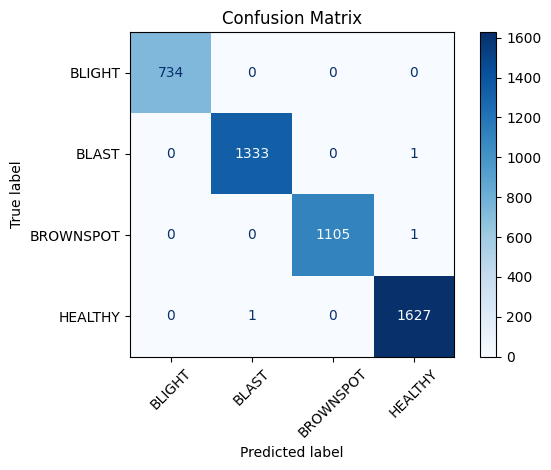

✅ Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\InceptionV3_Phase2_aug_noaug.h5


In [10]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\InceptionV3_Phase2_aug_noaug.h5"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")